## Imports

### Install packages

In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

### Import modules

In [2]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import msml610_utils as ut

ut.config_notebook()

# Setting notebook style
# Notebook signature
Python 3.12.3
Linux 8611c84637c0 6.10.14-linuxkit #1 SMP Tue Apr 15 16:00:54 UTC 2025 aarch64 aarch64 aarch64 GNU/Linux
numpy version=1.26.4
pymc version=5.18.2
matplotlib version=3.10.3
arviz version=0.21.0
preliz version=0.19.0


# Posterior predictive check: Examples

In [7]:
dir_name = "./Lesson07-data"

!ls $dir_name

anscombe.csv	     chemical_shifts_theo_exp.csv  islands.csv
anscombe_3.csv	     coal.csv			   penguins.csv
babies.csv	     dummy.csv			   pigs.csv
bikes.csv	     fish.csv			   redwood.csv
bikes_full.csv	     football_players.csv	   space_flu.csv
body_fat.csv	     horseshoe_crab.csv		   tips.csv
body_fat_full.csv    howell.csv
chemical_shifts.csv  iris.csv


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-1.081000,-0.888000,-0.623000,-0.4800,-0.505000,-0.345000,0.052000,0.061000,0.215000,0.395000,...,2.531000,2.765000,2.913000,3.168000,3.119000,3.385000,3.488000,3.538000,3.90,3.9700
1,1.168561,0.788544,0.388129,0.2304,0.255025,0.119025,0.002704,0.003721,0.046225,0.156025,...,6.405961,7.645225,8.485569,10.036224,9.728161,11.458225,12.166144,12.517444,15.21,15.7609


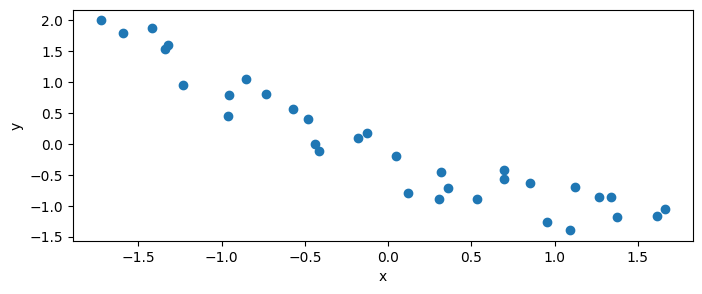

In [8]:
# Load some data it's mainly a linear relationship with some data.
dummy_data = np.loadtxt(dir_name + '/dummy.csv')
x = dummy_data[:, 0]
y = dummy_data[:, 1]

# Transform the data applying various powers and stacking the data, so that
# we have different rows with different predicted variables.
order = 2
x_p = np.vstack([x**i for i in range(1, order + 1)])
display(pd.DataFrame(x_p))

# Normalize all the data.
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()

# Plot the 0-order data (i.e., the original one).
plt.scatter(x_c[0], y_c)
plt.xlabel('x')
plt.ylabel('y');

In [12]:
ut.save_plt("Lesson07_Comparing_models_data.png")

![](lectures_source/figures/Lesson07_Comparing_models_data.png)


<Figure size 800x300 with 0 Axes>

In [9]:
# Linear model.
with pm.Model() as model_l:
    # mu = alpha + beta * x
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=10)
    mu = alpha + beta * x_c[0]
    #
    sigma = pm.HalfNormal('sigma', 5)
    #
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_c)
    #
    idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_l.extend(pm.sample_posterior_predictive(idata_l))
    

# Quadratic model.
with pm.Model() as model_p:
    # mu = alpha + beta_1 * x + beta_2 * x^2
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    # Beta is a 2-dim vector.
    beta = pm.Normal('beta', mu=0, sigma=10, shape=order)
    mu = alpha + pm.math.dot(beta, x_c)
    #
    sigma = pm.HalfNormal('sigma', 5)
    #
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_c)
    #
    idata_q = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_q.extend(pm.sample_posterior_predictive(idata_q))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y_pred]


Output()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_pred]


Output()

linear model: alpha_l_post=-0.00028, beta_l_post=-0.94
quadratic model: alpha_p_post=-0.00027, beta_post[0]=-1.5, beta_post[1]=0.56


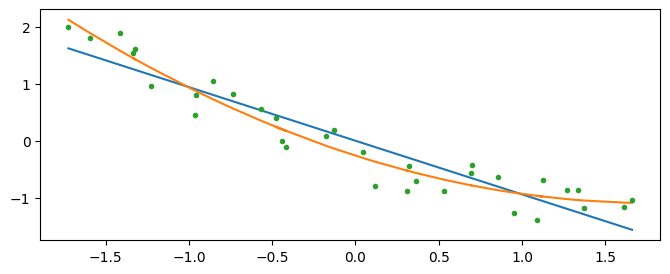

In [10]:
#
# Plot the data and the fit linear and quadratic models (using the mean posterior).
#

# Sample the x space uniformly with 100 samples.
x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

# Posterior.
posterior_l = az.extract(idata_l)
posterior_p = az.extract(idata_q)
#print(posterior_l)

# Compute the mean posterior of the linear model.
alpha_l_post = posterior_l["alpha"].mean().item()
beta_l_post = posterior_l["beta"].mean().item()
print(f"linear model: alpha_l_post={alpha_l_post:.2g}, beta_l_post={beta_l_post:.2g}")
y_l_post = alpha_l_post + beta_l_post * x_new

# Plot the mean posterior of the linear model.
plt.plot(x_new, y_l_post, "C0", label="linear model")

# Quadratic model.
alpha_p_post = posterior_p["alpha"].mean().item()
beta_p_post = posterior_p["beta"].mean("sample")
print(f"quadratic model: alpha_p_post={alpha_p_post:.2g}, beta_post[0]={beta_p_post[0]:.2g}, beta_post[1]={beta_p_post[1]:.2g}")
y_p_post = alpha_p_post + np.dot(beta_p_post, x_c)

#idx = np.argsort(x_c[0])
#plt.plot(x_c[0][idx], y_p_post[idx], "C1", label="quadratic model")
plt.plot(x_c[0], y_p_post, "C1", label="quadratic model")

# Plot data.
plt.plot(x_c[0], y_c, "C2.");

In [13]:
ut.save_plt("Lesson07_Comparing_models_model_fit.png")

![](lectures_source/figures/Lesson07_Comparing_models_model_fit.png)


<Figure size 800x300 with 0 Axes>

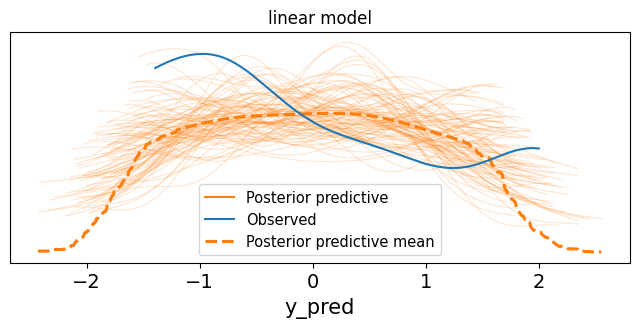

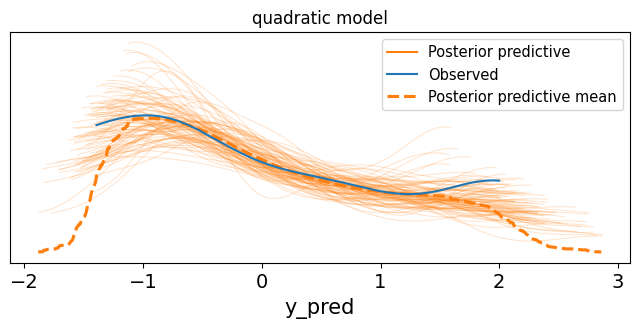

In [11]:
#
# Plot the posterior predictive check for both models.
#

az.plot_ppc(idata_l, num_pp_samples=100, colors=["C1", "C0", "C1"])
plt.title("linear model");

az.plot_ppc(idata_q, num_pp_samples=100, colors=["C1", "C0", "C1"])
plt.title("quadratic model");

In [14]:
ut.save_plt("Lesson07_Comparing_models_model_PPC.png")

![](lectures_source/figures/Lesson07_Comparing_models_model_PPC.png)


<Figure size 800x300 with 0 Axes>

In [46]:
#?az.plot_bpv

## Bayesian p-value

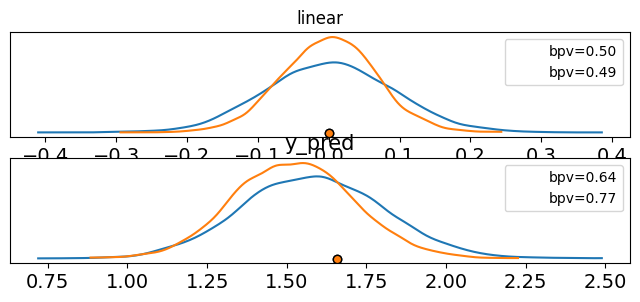

In [44]:
#
# Compare the Bayesian p-value for a statistic for linear and quadratic model.
#

colors = ["C0", "C1"]
idatas = [idata_l, idata_q]

fig, axes = plt.subplots(2, 1)

# Plot the Bayesian p-value for mean for both models.
for idata, c in zip(idatas, colors):
    # Plot Bayesian p-value.
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=axes[0], color=c)
    axes[0].set_title("linear")

# Plot the Bayesian p-value for interquartile range for both models.
def iqr(x, a=-1):
    """
    Interquartile range.
    """
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idata, c in zip(idatas, colors):
    # Plot Bayesian p-value.
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=axes[1], color=c)

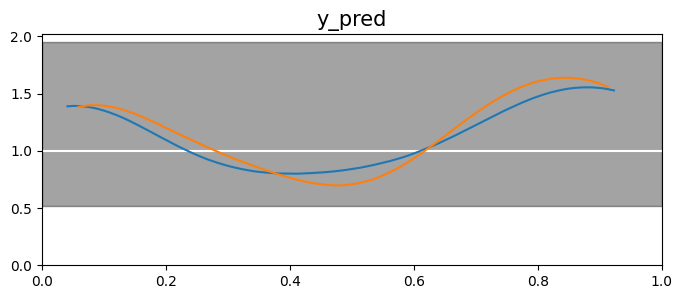

In [47]:
#
# Compare Bayesian p-value for entire distribution.
#

fig, ax = plt.subplots()

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, color=c, ax=ax)

# Overfitting

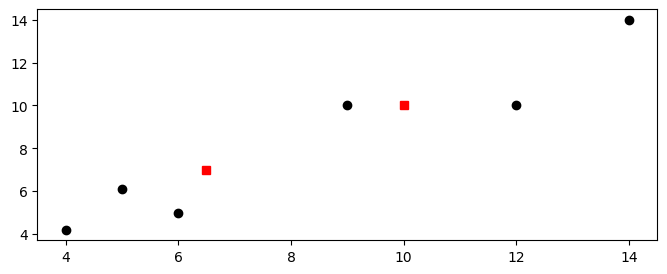

In [55]:
_, ax = plt.subplots(1, 1)

x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])
x1 = np.array([6.5, 10])
y1 = np.array([7, 10])

ax.plot(x0, y0, "ko");
ax.plot(x1, y1, "rs");

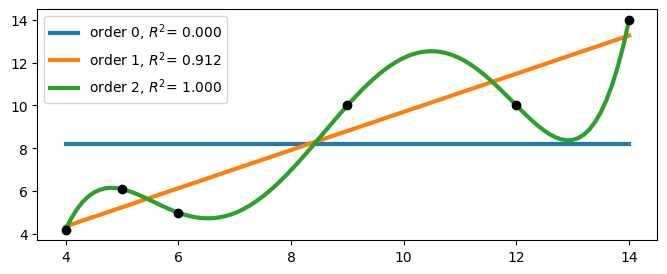

In [54]:
#
# Fit model on in-sample data.
#
_, ax = plt.subplots(1, 1)

# Data.
x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])
ax.plot(x0, y0, "ko", zorder=3)

# Learn 3 models.
order = [0, 1, 5]
x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    # Learn the models.
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)

# 
def plot_models(x0, y0, ps):
    for i in range(len(order)):
        p = ps[i]
        # Evaluate on the raw data.
        yhat = p(x0)
        # Estimate the error between the estimates and the true values.
        ss_regression = np.sum((yhat - y0) ** 2)
        # Compute R^2.
        ybar = np.mean(y0)
        ss_total = np.sum((ybar - y0) ** 2)
        r2 = 1 - ss_regression / ss_total
        #
        ax.plot(x_n, p(x_n), label=f"order {i}, $R^2$= {r2:.3f}", lw=3)
    ax.legend(loc=2)


plot_models(x0, y0, ps)

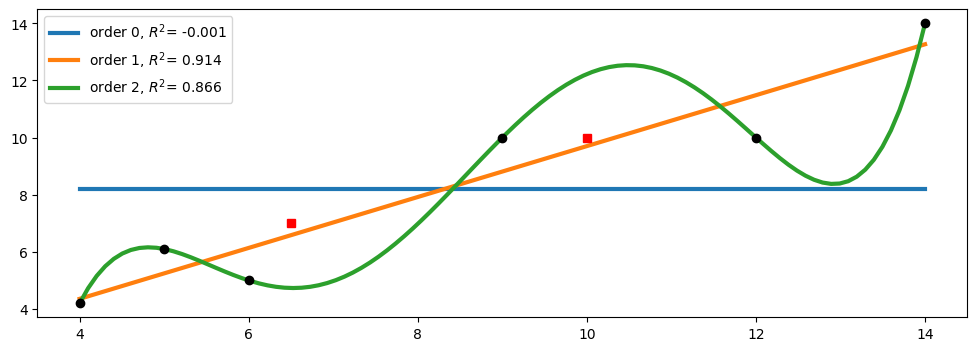

In [56]:
#
# Evaluate the fit model on the out-of-sample data.
#
_, ax = plt.subplots(figsize=(12, 4))
x_ = np.array([6.5, 10])
y_ = np.array([7, 10])

ax.plot(x0, y0, "ko", zorder=3)
ax.plot(x_, y_, "rs", zorder=3)

x1 = np.concatenate((x0, x_))
y1 = np.concatenate((y0, y_))

plot_models(x1, y1, ps)

## Calculating predictive accuracy

In [57]:
waic_l = az.waic(idata_l)
waic_l

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -14.38     2.67
p_waic        2.45        -

In [58]:
waic_q = az.waic(idata_q)
waic_q

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    -4.53     2.33
p_waic        2.61        -

In [59]:
loo_l = az.loo(idata_l)
loo_l

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -14.41     2.67
p_loo        2.48        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       33  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [60]:
loo_q = az.loo(idata_q)
loo_q

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -4.56     2.33
p_loo        2.64        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       33  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Comparing models

In [61]:
cmp_df = az.compare({
    "model_l": idata_l,
    "model_q": idata_q})
display(cmp_df)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_q,0,-4.557765,2.639365,0.000000,1.000000e+00,2.328892,0.00000,False,log
model_l,1,-14.408129,2.477674,9.850364,1.083578e-13,2.673772,2.68335,False,log


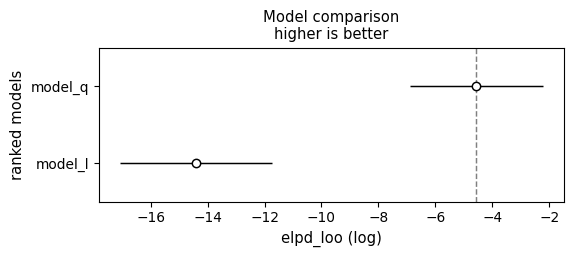

In [62]:
az.plot_compare(cmp_df);

## Model averaging

In [63]:
idatas = [idata_l, idata_q]
weights = [0.35, 0.65]
idata_w = az.weight_predictions(idatas, weights)

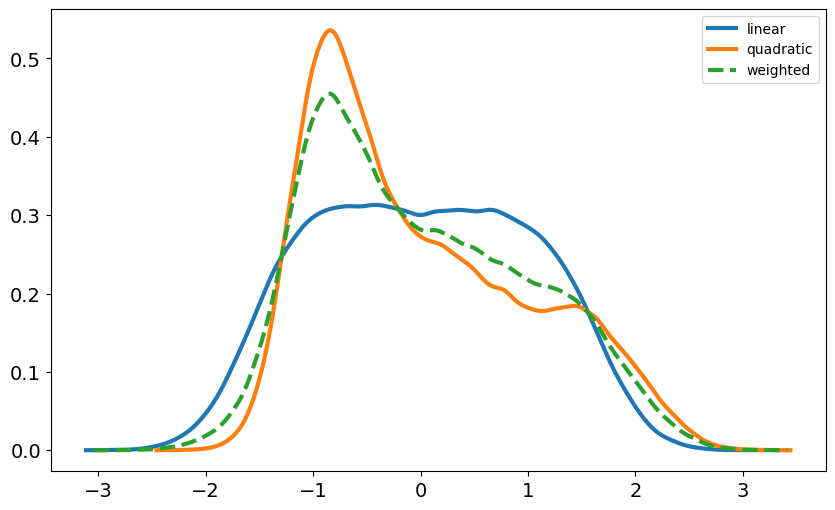

In [64]:
# Plot the KDE of the posterior predictive.
_, ax = plt.subplots(figsize=(10, 6))

# Linear.
az.plot_kde(
    idata_l.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="linear",
    ax=ax,
)

# Quadratic.
az.plot_kde(
    idata_q.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="quadratic",
    ax=ax,
)

# Weighted.
az.plot_kde(
    idata_w.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)

plt.legend();

# Mixture models

## Marginalization

In [67]:
!ls $dir_name

anscombe.csv	     chemical_shifts_theo_exp.csv  islands.csv
anscombe_3.csv	     coal.csv			   penguins.csv
babies.csv	     dummy.csv			   pigs.csv
bikes.csv	     fish.csv			   redwood.csv
bikes_full.csv	     football_players.csv	   space_flu.csv
body_fat.csv	     horseshoe_crab.csv		   tips.csv
body_fat_full.csv    howell.csv
chemical_shifts.csv  iris.csv


In [71]:
cs = pd.read_csv(dir_name + "/chemical_shifts_theo_exp.csv")
cs_exp = pd.DataFrame(cs["exp"])
display(cs_exp.head())
print("shape=", len(cs_exp))

,exp
0,58.27
1,56.18
2,56.84
3,51.01
4,54.64


shape= 1776


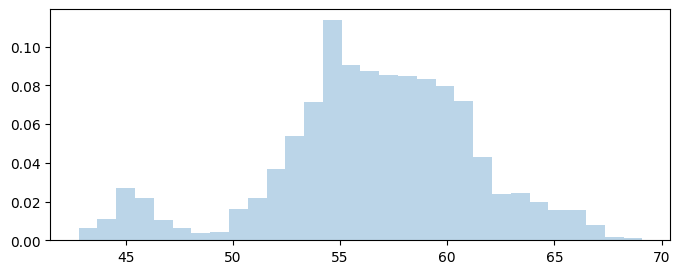

In [72]:
_, ax = plt.subplots()
plt.hist(cs_exp, density=True, bins=30, alpha=0.3);

In [73]:
# The parameters to estimate are:
# - latent variable (which is a vector with as many components as data points) coming from a Dirichlet
#   - All vars are estimated together as hierarchical model.
# - distributions of the 2 Gaussians
K = 2
with pm.Model() as model_kg:
    # Prior p ~ Dirichlet([1, 1]), which is a Beta.
    p = pm.Dirichlet("p", a=np.ones(K))
    # Assign each data point a RV with a Dirichlet prior, using latent variable "z".
    z = pm.Categorical("z", p=p, shape=len(cs_exp))
    # 2 Gaussians with different mean and same std.
    means = pm.Normal("means", mu=cs_exp.mean(), sigma=10, shape=K)
    sd = pm.HalfNormal("sd", sigma=10)
    # The distribution is a Gaussian whose means are function of the latent variable.
    y = pm.Normal("y", mu=means[z], sigma=sd, observed=cs_exp)
    trace_kg = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, means, sd]
>BinaryGibbsMetropolis: [z]


Output()

ValueError: Not enough samples to build a trace.

In [ ]:
varnames = ["means", "p"]
az.plot_trace(trace_kg, varnames);

# Inference engines

## Grid method

In [80]:
heads = 3
tails = 10
grid_points = 20
grid = np.linspace(0, 1, grid_points)

In [83]:
def posterior_grid(grid_points, heads, tails):
    # The interval for the parameter is [0, 1].
    grid = np.linspace(0, 1, grid_points)
    # The prior is uniform.
    prior = np.repeat(1 / grid_points, grid_points)
    # Likelihood is Binomial with known params.
    likelihood = pz.Binomial(n = heads + tails, p = grid).pdf(heads)
    # Compute the integral of the PDF.
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, prior, likelihood, posterior

h= 3
t= 10


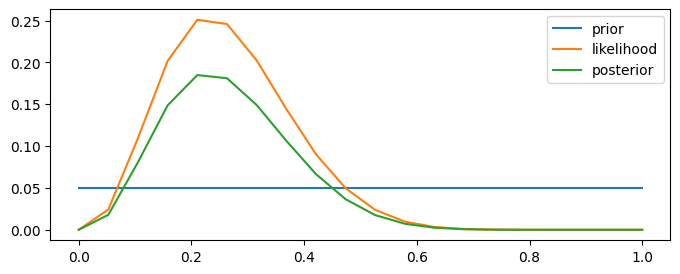

In [86]:
# Data.
# h = 10
# t = 3
h = 3
t = 10
print("h=", h)
print("t=", t)

grid, prior, likelihood, posterior = posterior_grid(grid_points, h, t)

# Plot posterior.
plt.plot(grid, prior, label="prior")
plt.plot(grid, likelihood, label="likelihood")
plt.plot(grid, posterior, label="posterior")
plt.legend();

In [ ]:
## Monte Carlo pi

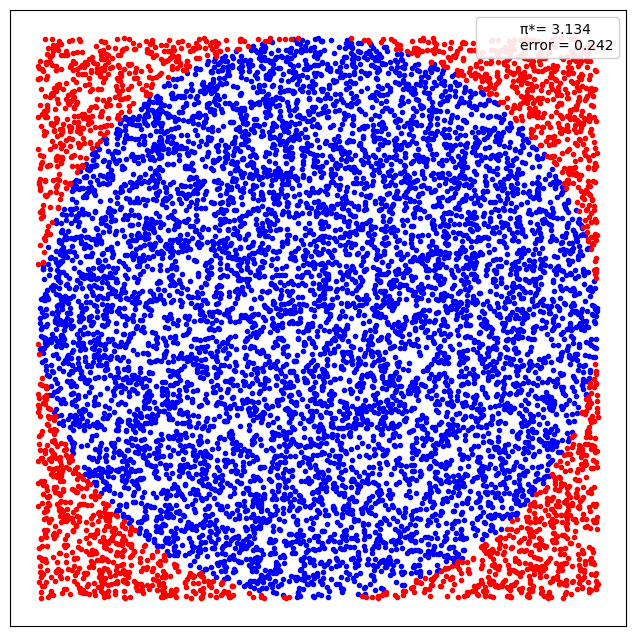

In [88]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100
 
outside = np.invert(inside)
 
plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc=1, frameon=True, framealpha=0.9);

In [89]:
def metropolis(func, draws=10000):
    """
    A very simple Metropolis implementation.
    """
    # Initialize an array to store sampled values.
    trace = np.zeros(draws)
    # Start at an initial value for the chain and compute its probability.
    old_x = 0.5  # func.mean()
    old_prob = func.pdf(old_x)
    # Generate proposal deltas from a normal distribution.
    delta = np.random.normal(0, 0.5, draws)
    # Loop through the desired number of samples.
    for i in range(draws):
        # Propose a new sample by adding the delta to the current state.
        new_x = old_x + delta[i]
        # Compute the probability of the proposed sample.
        new_prob = func.pdf(new_x)
        # Calculate acceptance ratio between proposed and current probabilities.
        acceptance = new_prob / old_prob
        # Accept or reject the new sample based on the acceptance ratio.
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x
    # Return the full trace of sampled values.
    return trace

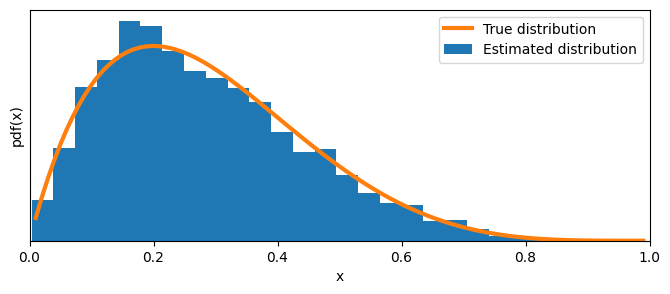

In [90]:
np.random.seed(3)
func = stats.beta(2, 5) 
trace = metropolis(func=func) 
x = np.linspace(0.01, .99, 100) 
y = func.pdf(x) 
plt.xlim(0, 1) 
plt.plot(x, y, 'C1-', lw=3, label='True distribution') 
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution') 
plt.xlabel('x') 
plt.ylabel('pdf(x)')
plt.yticks([]) 
plt.legend()
plt.savefig('B11197_08_05.png');

# Diagnosing convergence

In [91]:
# Centered model.
with pm.Model() as model_c:
    # Param for the std dev of all Gaussians.
    a = pm.HalfNormal('a', 10)
    # 10 normals with mean=0 and std dev=a.
    b = pm.Normal('b', 0, a, shape=10)
    idata_c = pm.sample(random_seed=73)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


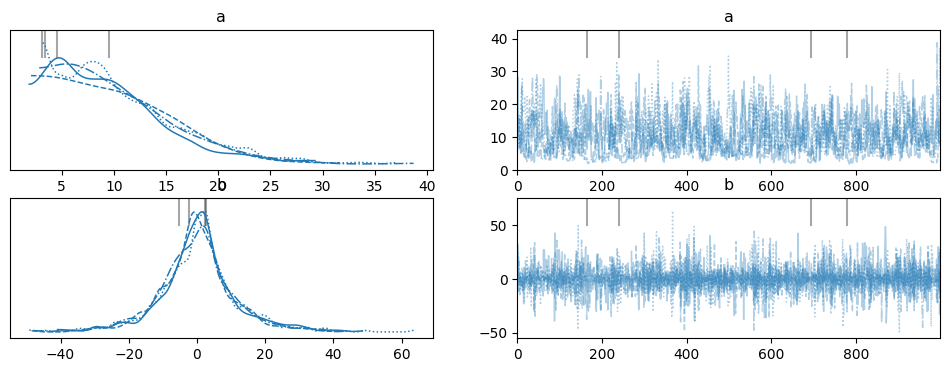

In [93]:
coords={'b_dim_0': [0]}
az.plot_trace(idata_c, var_names=['a', "b"], coords=coords, divergences='top');

In [92]:
# Non-centered (re-parametrized) model.
with pm.Model() as model_nc:
    a = pm.HalfNormal('a', 10)
    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=10)
    # Gaussians are rescaled.
    b = pm.Deterministic('b', 0 + b_offset * a)
    #idata_nc = pm.sample(random_seed=73, target_accept=0.9)
    idata_nc = pm.sample(random_seed=73)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


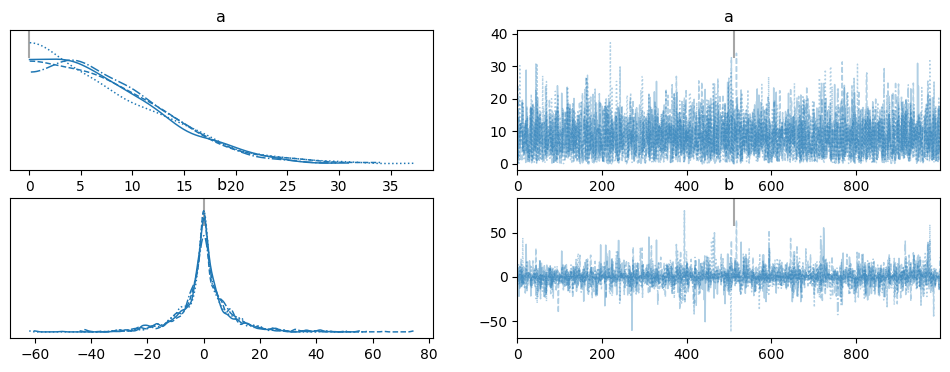

In [94]:
ax = az.plot_trace(idata_nc, var_names=['a', "b"], coords=coords, divergences='top')

## Rank plot

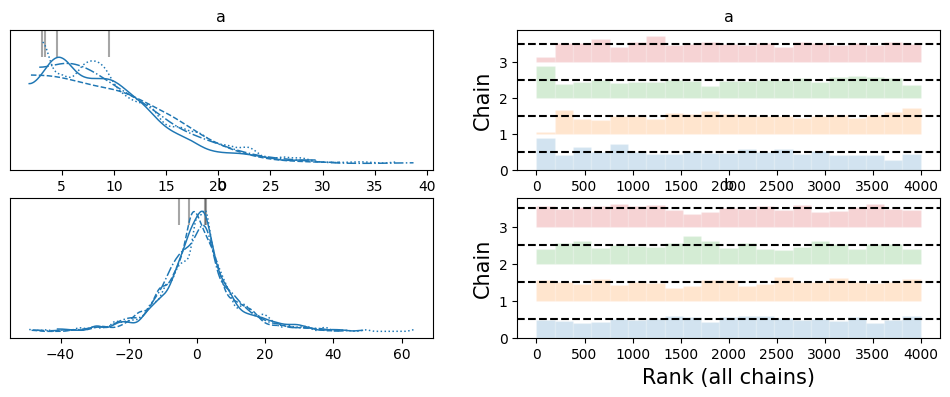

In [95]:
az.plot_trace(idata_c, var_names=['a', "b"], divergences='top', kind='rank_bars', coords=coords);

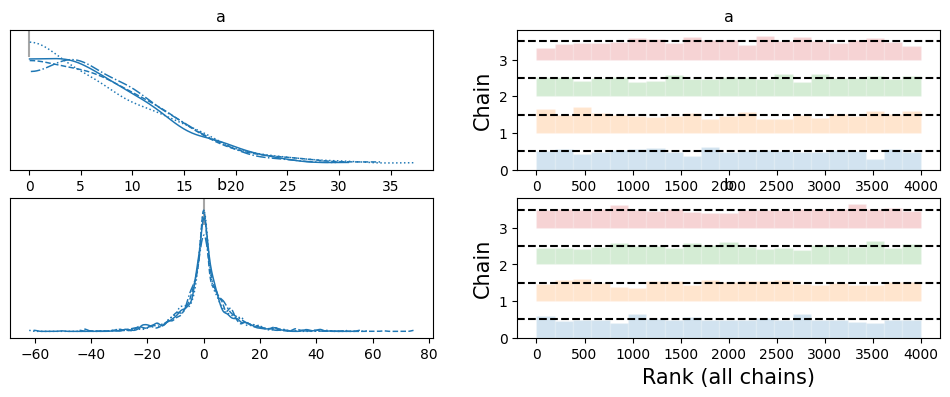

In [96]:
az.plot_trace(idata_nc, var_names=['a', "b"], divergences='top', kind='rank_bars', coords=coords);

In [102]:
summaries = pd.concat([
   az.summary(idata_c, var_names=['a']),
   az.summary(idata_nc, var_names=['a'])])
summaries.index = ['centered', 'non_centered']
summaries

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
centered,10.049,5.543,2.163,20.164,0.274,0.116,309.0,205.0,1.01
non_centered,8.038,5.888,0.016,18.315,0.083,0.092,3699.0,2154.0,1.00


## R hat

In [97]:
az.rhat(idata_c, var_names="a b".split()).to_dataframe().T

b_dim_0,0,1,2,3,4,5,6,7,8,9
a,1.011287,1.011287,1.011287,1.011287,1.011287,1.011287,1.011287,1.011287,1.011287,1.011287
b,1.002751,1.001871,1.001672,1.005625,1.007835,1.007884,1.003178,1.005610,1.003955,1.002469


In [98]:
az.rhat(idata_nc, var_names="a b".split()).to_dataframe().T

b_dim_0,0,1,2,3,4,5,6,7,8,9
a,1.001375,1.001375,1.001375,1.001375,1.001375,1.001375,1.001375,1.001375,1.001375,1.001375
b,1.000028,1.002060,1.000808,1.000455,0.999762,1.000170,1.001314,1.000038,1.000857,1.001186


## ESS

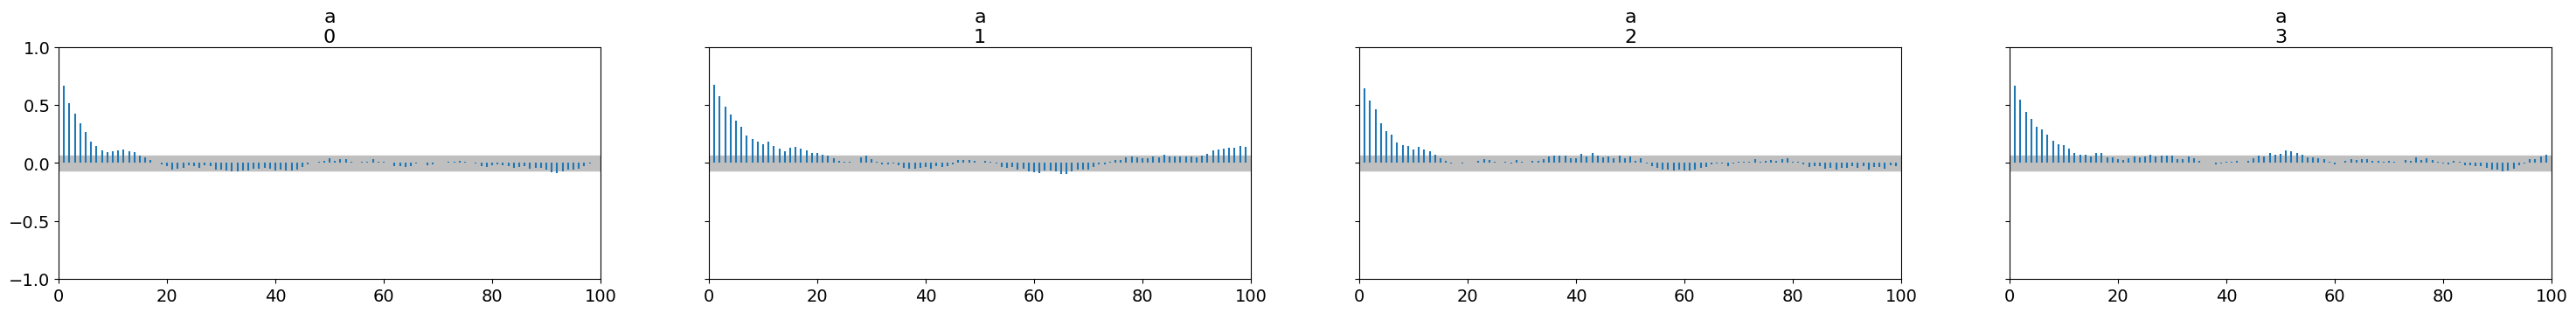

In [107]:
az.plot_autocorr(idata_c, var_names=['a']);

In [99]:
az.ess(idata_c, var_names="a b".split()).to_dataframe().T

b_dim_0,0,1,2,3,4,5,6,7,8,9
a,308.909719,308.909719,308.909719,308.909719,308.909719,308.909719,308.909719,308.909719,308.909719,308.909719
b,5860.990742,4693.349525,5012.626553,5168.924254,5870.690648,4260.339410,5218.745252,4361.685998,5854.790142,5388.203409


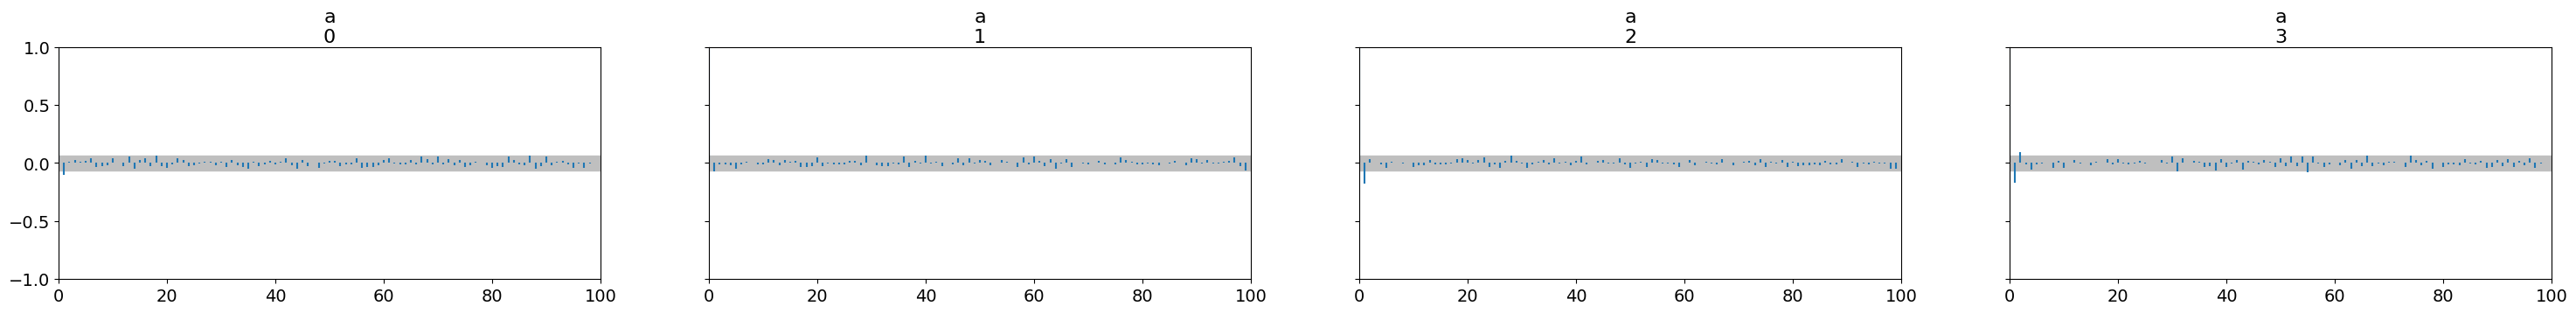

In [109]:
az.plot_autocorr(idata_nc, var_names=['a']);

In [100]:
az.ess(idata_nc, var_names="a b".split()).to_dataframe().T

b_dim_0,0,1,2,3,4,5,6,7,8,9
a,3699.053894,3699.053894,3699.053894,3699.053894,3699.053894,3699.053894,3699.053894,3699.053894,3699.053894,3699.053894
b,4773.770461,4363.343875,4551.954210,4301.315547,5677.599167,4988.881619,5159.232553,5459.407442,4032.794749,5395.419771


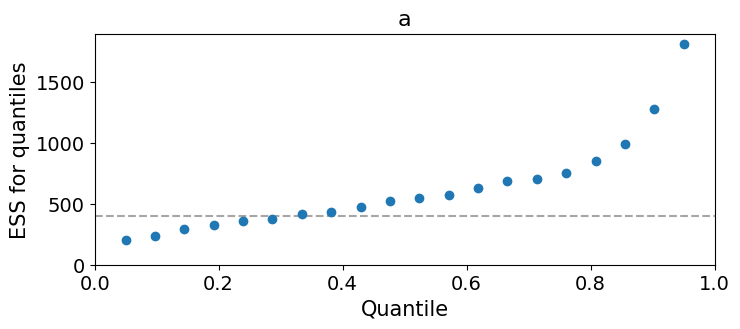

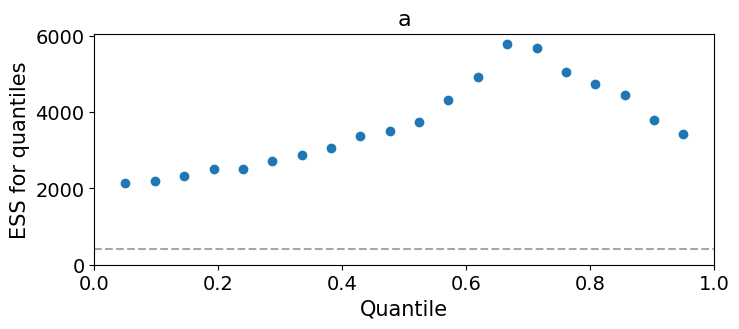

In [111]:
# Plot the ESS by quantile.
az.plot_ess(idata_c, var_names="a", kind="quantile")
az.plot_ess(idata_nc, var_names="a", kind="quantile");

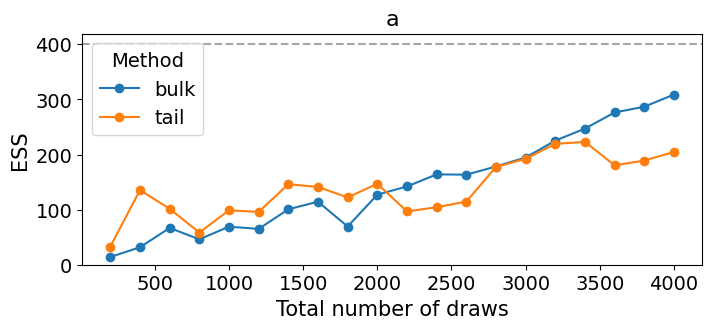

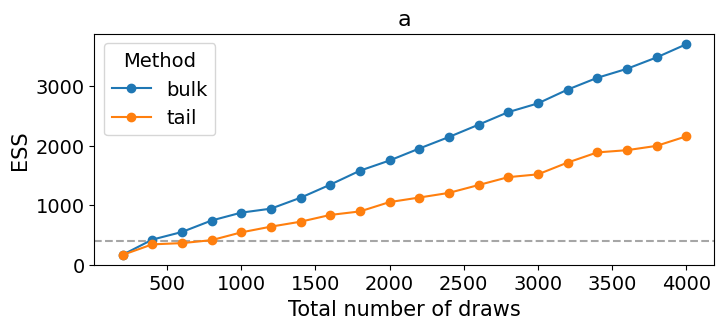

In [112]:
az.plot_ess(idata_c, var_names="a", kind="evolution")
az.plot_ess(idata_nc, var_names="a", kind="evolution");

## Divergences

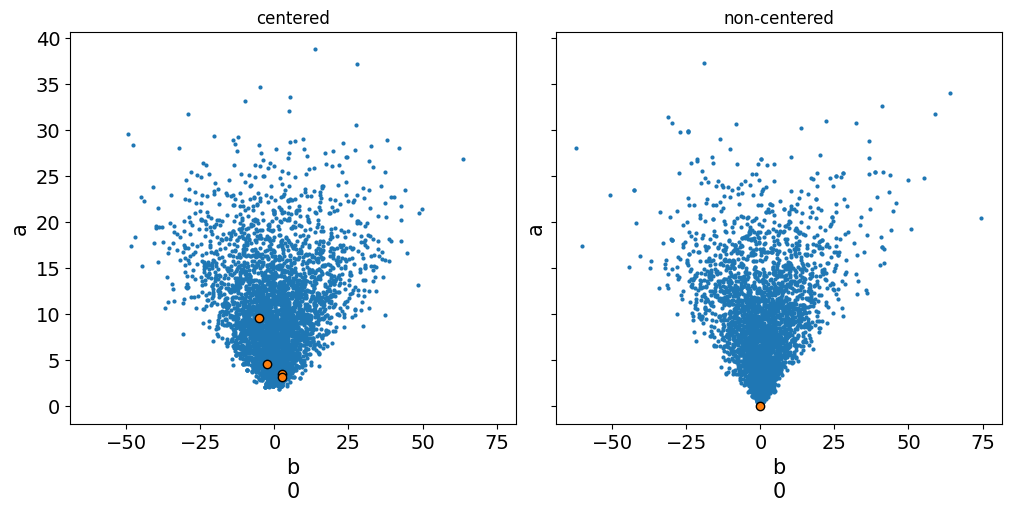

In [116]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)

for idx, tr in enumerate([idata_c, idata_nc]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]}, kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

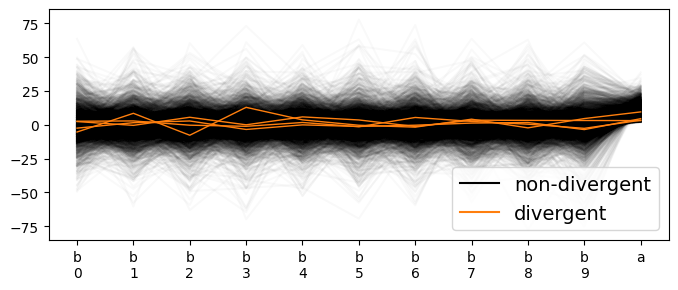

In [119]:
az.plot_parallel(idata_c);

<Axes: >

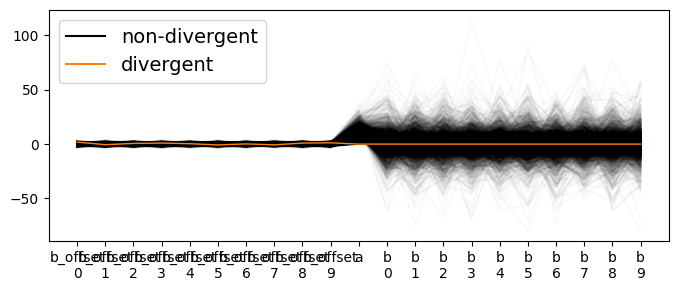

In [118]:
az.plot_parallel(idata_nc);